In [1]:
# import libraries
import os
import time
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle5 as pickle
from functools import reduce

import helpers as helper

#### Metadata from raw data file

In [2]:
# load data
with open('../../data/WM-clean.pkl', "rb") as fh:
    raw_data = pickle.load(fh)

# add index column to identify specific wafers 
raw_data.reset_index(inplace=True)
raw_data = raw_data.rename(columns={'index':'ID', 'shape': 'dims'})

# add detection model labels
raw_data['detectLabels'] = raw_data['failureType'].apply(lambda x: 0 if x == 'none' else 1)

# add classification model labels
fail_dict = {'none': 8, 'Loc': 0, 'Edge-Loc': 1, 'Center': 2, 'Edge-Ring': 3, 
             'Scratch': 4, 'Random': 5, 'Near-full': 6, 'Donut': 7}
raw_data['classifyLabels'] = raw_data['failureType'].apply(lambda x: fail_dict[x])

# keep only test set
test = raw_data[raw_data.dataset == 'test'].reset_index(drop=True)

# collect metadata
metadata = test[['ID', 'waferMap', 'dieSize', 'lotName', 'dims', 'failureType', 'detectLabels', 'classifyLabels']]
print(metadata.shape)
metadata.head()

(25943, 8)


,ID,waferMap,dieSize,lotName,dims,failureType,detectLabels,classifyLabels
0,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,0,8
1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,0,8
2,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,0,8
3,10,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,0,8
4,11,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,0,8


#### Load results from all detect models

In [3]:
with open('../results/yudetect-paper.pkl', "rb") as fh:
    paper = pickle.load(fh)

with open('../results/yudetect-224.pkl', "rb") as fh:
    d224 = pickle.load(fh)

with open('../results/yudetect-224-thin2.pkl', "rb") as fh:
    d224thin2 = pickle.load(fh)

with open('../results/yudetect-224-thin4.pkl', "rb") as fh:
    d224thin4 = pickle.load(fh)
    
with open('../results/yudetect-60.pkl', "rb") as fh:
    d60 = pickle.load(fh)

with open('../results/yudetect-60-mfilter3.pkl', "rb") as fh:
    d60m3 = pickle.load(fh)

with open('../results/yudetect-60-thin2.pkl', "rb") as fh:
    d60thin2 = pickle.load(fh)

dfs = [paper, d224, d224thin2, d224thin4, d60, d60m3, d60thin2]
df_names = ['paper', 'd224', 'd224thin2', 'd224thin4', 'd60', 'd60m3', 'd60thin2']

In [4]:
# collect metadata and predictions in one dataframe
analysis = metadata.copy()

for df, col in zip(dfs, df_names):
    analysis[col] = df[0].tolist()
    
analysis.head()

,ID,waferMap,dieSize,lotName,dims,failureType,detectLabels,classifyLabels,paper,d224,d224thin2,d224thin4,d60,d60m3,d60thin2
0,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,0,8,0,0,0,0,0,0,0
1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,0,8,0,0,0,0,0,0,0
2,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,0,8,0,0,0,0,0,0,0
3,10,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,0,8,0,0,0,0,0,0,0
4,11,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,"(45, 48)",none,0,8,0,0,0,0,0,0,0


#### Explore paper mislabeled

In [5]:
# make list of IDs of misclassified wafers
dfs = [paper, d224, d224thin2, d224thin4, d60, d60m3, d60thin2]
id_lists = [paperid:=[], d224id:=[], d224thin2id:=[], d224thin4id:=[], d60id:=[], d60m3id:=[], d60thin2id:=[]]

for x, y in zip(id_lists, dfs):
    x.extend([metadata.ID[i] for i in range(len(metadata)) if y[0][i] != metadata.detectLabels[i]])
    print(len(x))

536
677
507
729
1007
858
1129


In [6]:
# keep only subset of paper mislabeled wafers
paper_indices = [analysis.index[analysis.ID == i][0] for i in paperid]
paper_miss = analysis.loc[paper_indices].reset_index(drop=True)
len(paper_miss)

536

In [7]:
paper_miss.groupby('failureType')['failureType'].count().sort_values(ascending=False)

failureType
none         307
Edge-Loc      65
Scratch       57
Loc           48
Center        30
Edge-Ring     26
Donut          2
Random         1
Name: failureType, dtype: int64

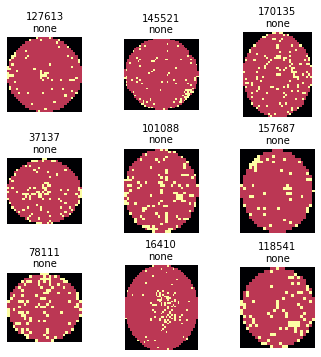

In [8]:
mistakes = [i for i in range(len(paper_miss)) if paper_miss.iloc[i].failureType == 'none']
random_n = random.sample(mistakes, 9)
helper.plot_list(paper_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

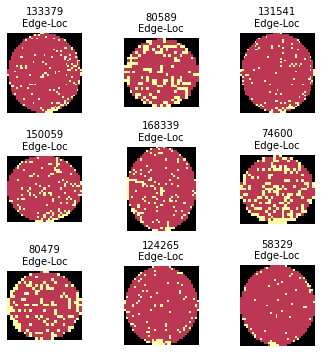

In [9]:
mistakes = [i for i in range(len(paper_miss)) if paper_miss.iloc[i].failureType == 'Edge-Loc']
random_n = random.sample(mistakes, 9)
helper.plot_list(paper_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

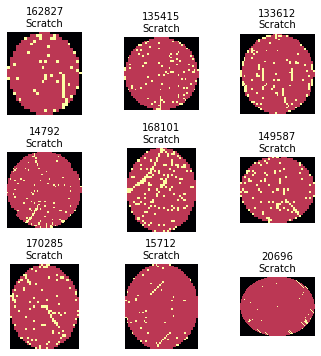

In [10]:
mistakes = [i for i in range(len(paper_miss)) if paper_miss.iloc[i].failureType == 'Scratch']
random_n = random.sample(mistakes, 9)
helper.plot_list(paper_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

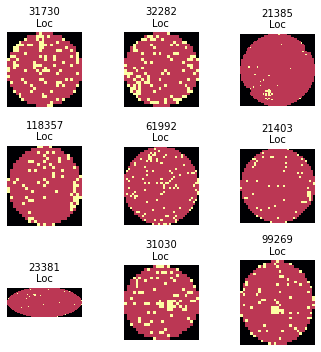

In [11]:
mistakes = [i for i in range(len(paper_miss)) if paper_miss.iloc[i].failureType == 'Loc']
random_n = random.sample(mistakes, 9)
helper.plot_list(paper_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

#### Explore thinned mislabeled

In [12]:
# keep only subset of thinned mislabeled wafers
thin_indices = [analysis.index[analysis.ID == i][0] for i in d224thin2id]
thin_miss = analysis.loc[thin_indices].reset_index(drop=True)
len(thin_miss)

507

In [13]:
thin_miss.groupby('failureType')['failureType'].count().sort_values(ascending=False)

failureType
none         168
Edge-Loc      99
Loc           98
Scratch       67
Center        51
Edge-Ring     21
Donut          3
Name: failureType, dtype: int64

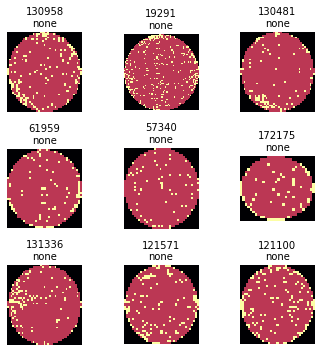

In [14]:
mistakes = [i for i in range(len(thin_miss)) if thin_miss.iloc[i].failureType == 'none']
random_n = random.sample(mistakes, 9)
helper.plot_list(thin_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

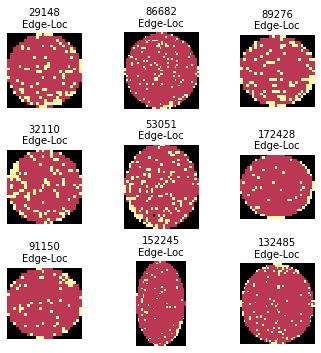

In [15]:
mistakes = [i for i in range(len(thin_miss)) if thin_miss.iloc[i].failureType == 'Edge-Loc']
random_n = random.sample(mistakes, 9)
helper.plot_list(thin_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

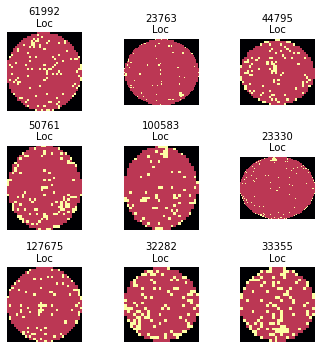

In [16]:
mistakes = [i for i in range(len(thin_miss)) if thin_miss.iloc[i].failureType == 'Loc']
random_n = random.sample(mistakes, 9)
helper.plot_list(thin_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

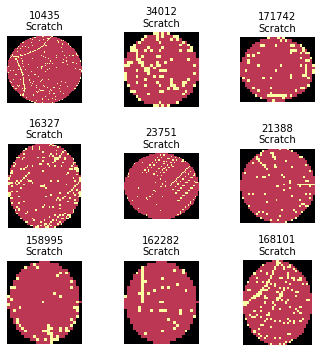

In [17]:
mistakes = [i for i in range(len(thin_miss)) if thin_miss.iloc[i].failureType == 'Scratch']
random_n = random.sample(mistakes, 9)
helper.plot_list(thin_miss, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

#### Most mislabeled

In [18]:
# apply intersect1d to (a list of) multiple lists:
intersection = reduce(np.intersect1d, id_lists[:3])
len(intersection)

210

In [19]:
# keep only subset of most mislabeled wafers
miss_indices = [analysis.index[analysis.ID == i][0] for i in intersection]
misclassified = analysis.loc[miss_indices].reset_index(drop=True)
len(misclassified)

210

In [20]:
misclassified.groupby('failureType')['failureType'].count().sort_values(ascending=False)

failureType
none         90
Edge-Loc     36
Scratch      33
Loc          26
Center       17
Edge-Ring     8
Name: failureType, dtype: int64

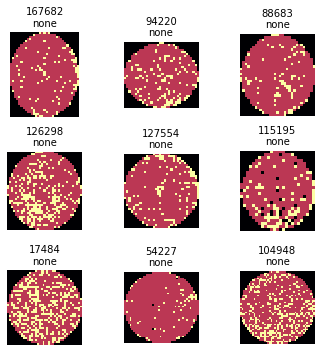

In [21]:
mistakes = [i for i in range(len(misclassified)) if misclassified.iloc[i].failureType == 'none']
random_n = random.sample(mistakes, 9)
helper.plot_list(misclassified, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

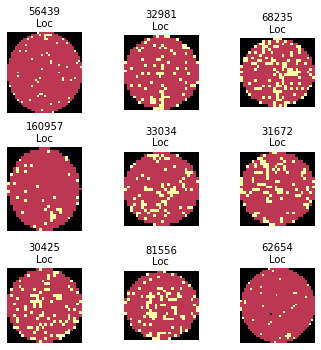

In [22]:
mistakes = [i for i in range(len(misclassified)) if misclassified.iloc[i].failureType == 'Loc']
random_n = random.sample(mistakes, 9)
helper.plot_list(misclassified, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

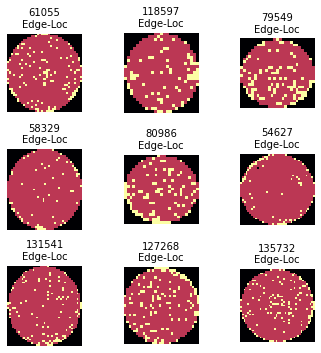

In [23]:
mistakes = [i for i in range(len(misclassified)) if misclassified.iloc[i].failureType == 'Edge-Loc']
random_n = random.sample(mistakes, 9)
helper.plot_list(misclassified, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')

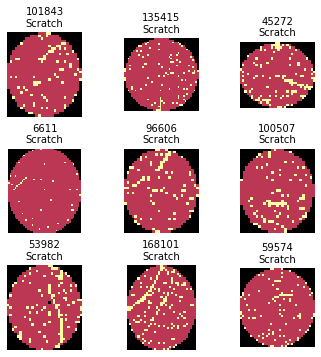

In [24]:
mistakes = [i for i in range(len(misclassified)) if misclassified.iloc[i].failureType == 'Scratch']
random_n = random.sample(mistakes, 9)
helper.plot_list(misclassified, random_n, fig_size=(5,5), col='waferMap', cmap='inferno')